In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as ticker
from jupyterthemes import jtplot
jtplot.style()

from api.questrade import QTClient

In [66]:
REFRESH_TOKEN = "sUMava8sct5goG1xwpiM3coy0v155QDE0"

In [67]:
client = QTClient(REFRESH_TOKEN)

# Show Open PnL

In [68]:
positions = pd.DataFrame(client.get_account_positions())
positions

,averageEntryPrice,closedPnl,closedQuantity,currentMarketValue,currentPrice,dayPnl,isRealTime,isUnderReorg,openPnl,openQuantity,symbol,symbolId,totalCost
0,40.800000,0,0,191.00,38.20,0.80,False,False,-13.000000,5,ROBO,4807280,204.000000
1,23.510000,0,0,240.70,24.07,0.60,False,False,5.600000,10,TAN,21806477,235.100000
2,23.398317,0,0,234.96,19.58,2.28,False,False,-45.819804,12,BOTZ,15029143,280.779804


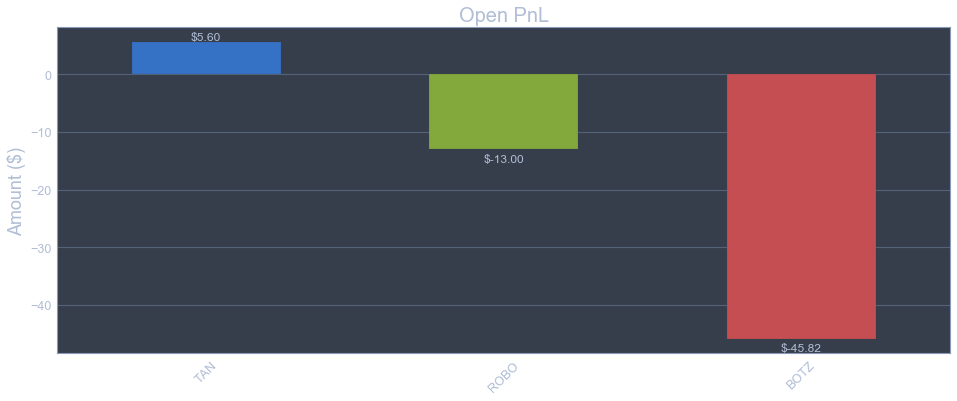

In [70]:
%matplotlib inline
positions.sort_values(by=['openPnl'], inplace=True, ascending=False)
ax = positions.plot(x='symbol', y='openPnl', kind='bar', figsize=(16, 6), legend=False)
ax.set_title('Open PnL', fontsize=20)
ax.set_ylabel('Amount ($)', fontsize=18)
ax.set_xlabel('')
ax.grid(axis='x')
rects = ax.patches
for rect, label in zip(rects, positions['openPnl']):
    height = rect.get_height()
    if height < 0:
        height -= 2.5
    ax.text(rect.get_x() + rect.get_width() / 2, height, '$%.2f' % label,
            ha='center', va='bottom', fontsize=12)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [71]:
print("Open PnL: %f" % (positions['openPnl'].sum()))

Open PnL: -53.219804


# Read historical market data from CSV

In [72]:
historicals = pd.read_csv("historicals.csv")
historicals['end'] =  pd.to_datetime(historicals['end'], format='%Y-%m-%d')
historicals = historicals.set_index(["symbol", "end"])

# Historical analysis


## Plot individual securities historical time series

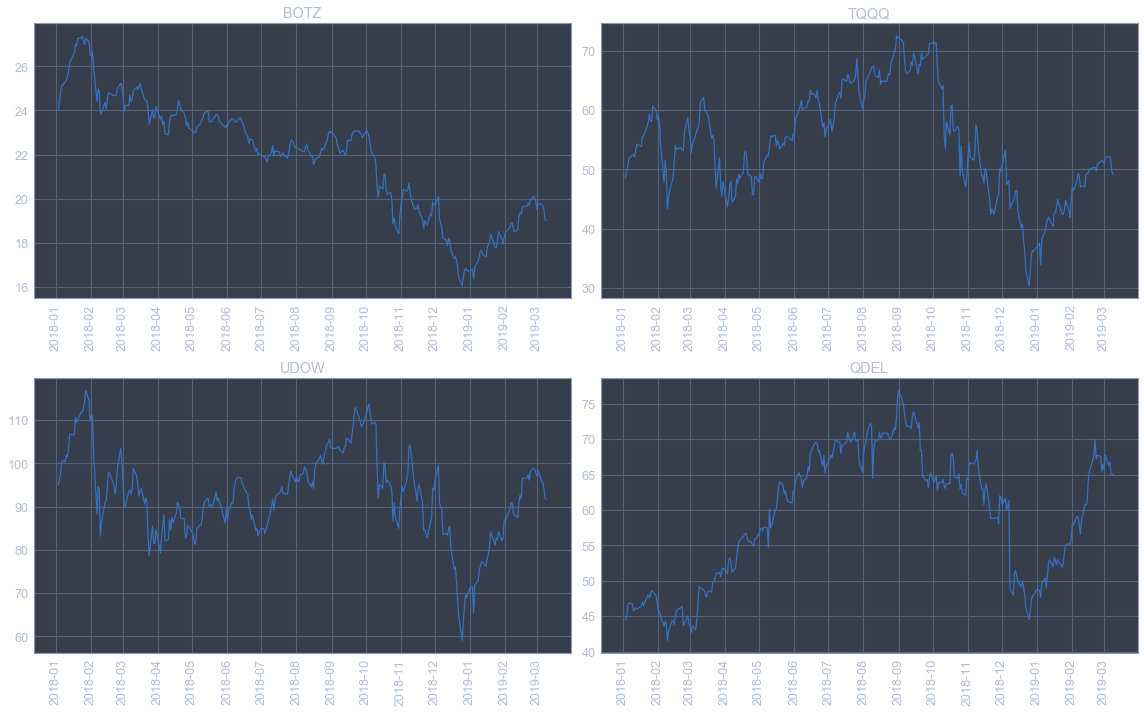

In [157]:
import matplotlib.dates as mdates
months = mdates.MonthLocator(interval=1, bymonthday=1)
m_fmt = mdates.DateFormatter('%Y-%m')

def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def plot_historicals(symbols, start_date):
    filtered_df = historicals[(historicals.index.get_level_values('symbol').isin(symbols)) &
                              (historicals.index.get_level_values('end') > start_date)
                             ]
    symbol_chunks = chunks(list(filtered_df.index.unique(level='symbol')), 4)
    for chunk in symbol_chunks:
        rows = math.ceil(len(chunk) / 2)
        fig, axs = plt.subplots(figsize=(16,10), nrows=rows, ncols=2)
        targets = zip(chunk, axs.flatten())
        for i, (key, ax) in enumerate(targets):
            ax.plot(filtered_df[filtered_df.index.get_level_values('symbol')==key].unstack(level=0)['close'])
            ax.set_title(key)
            ax.xaxis.set_major_locator(months)
            ax.xaxis.set_major_formatter(m_fmt)
            for tick in ax.get_xticklabels():
                tick.set_rotation(90)
        plt.tight_layout()
        plt.show()
plot_historicals(["BOTZ", "TQQQ", "UDOW", "QDEL"], 
                 start_date=pd.to_datetime("2018-01-01", format='%Y-%m-%d'))

## Calculate time series features

### Daily return

In [141]:
historicals['daily_returns'] = historicals.groupby(level='symbol')['close'].apply(lambda x: x.pct_change())

### Total return

In [139]:
def get_total_return(start_date, df):
    return df[df.index.get_level_values('end') > start_date].groupby(level='symbol')['daily_returns'].apply(lambda x: (1 + x).cumprod() - 1)

## Calculate total returns

In [179]:
historicals["total_returns"] = get_total_return(pd.to_datetime("2011-01-01", format='%Y-%m-%d'), historicals)

## Show all total returns

<Figure size 1152x432 with 0 Axes>

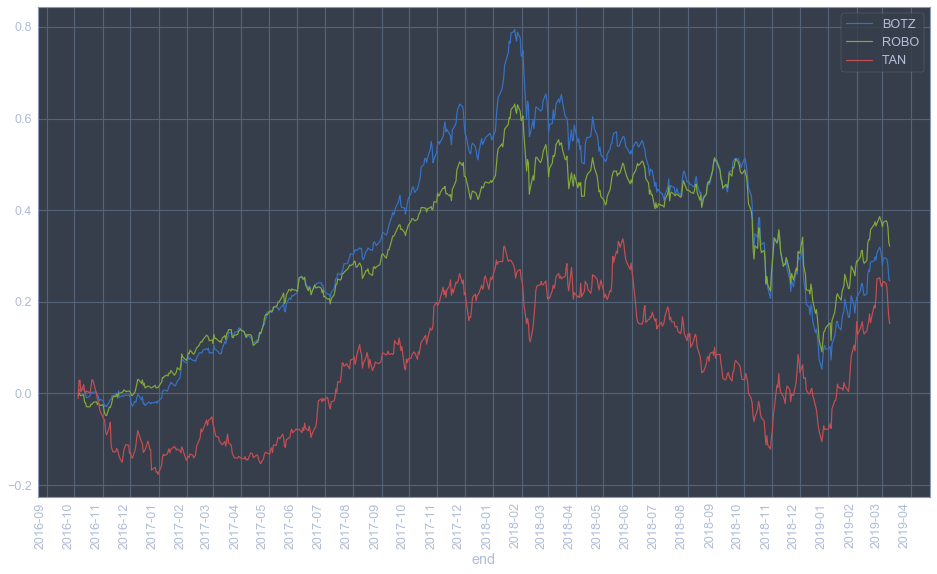

In [180]:
import matplotlib.dates as mdates
months = mdates.MonthLocator(interval=1, bymonthday=1)

plt.figure(figsize=(16, 6))
fig, ax = plt.subplots(figsize=(16,10))
historicals[historicals.index.get_level_values('symbol').isin(list(positions['symbol']))].reset_index().set_index("end").groupby('symbol')['total_returns'].plot(legend=True)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(m_fmt)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [146]:
historicals.groupby(level="symbol")["total_returns"].nth(-1).sort_values()

symbol
TVIX       -0.557422
MVRBF      -0.553398
UVXY       -0.451293
HOD.TO     -0.365237
SQQQ       -0.305312
FAZ        -0.285201
SDOW       -0.272040
SPXS       -0.270091
SPXU       -0.268660
HNU.TO     -0.239908
SGAMF      -0.205307
SDS        -0.184168
EDZ        -0.180003
WEAT       -0.149254
RWM        -0.122531
PCY.TO     -0.111111
HIX.TO     -0.105970
HIU.TO     -0.096406
SH         -0.094185
UNG        -0.078832
SCRPF      -0.074946
ULE        -0.044515
DBA        -0.039481
CORN       -0.038927
CYB.TO     -0.034813
HNY.TO     -0.033233
SVR.C.TO   -0.026474
AGQ        -0.026074
FXF        -0.025111
HBD.TO     -0.024725
              ...   
DZK         0.234447
BRZU        0.237309
SMLR        0.242424
PHX.TO      0.246753
TAN         0.248788
YINN        0.267088
UWM         0.287634
FM.TO       0.303621
UPRO        0.327133
SPXL        0.328647
CNXT        0.330005
UDOW        0.330577
SLXXF       0.333929
QDEL        0.354362
TQQQ        0.356985
FAS         0.367987
TNA   

## Calculate correlations

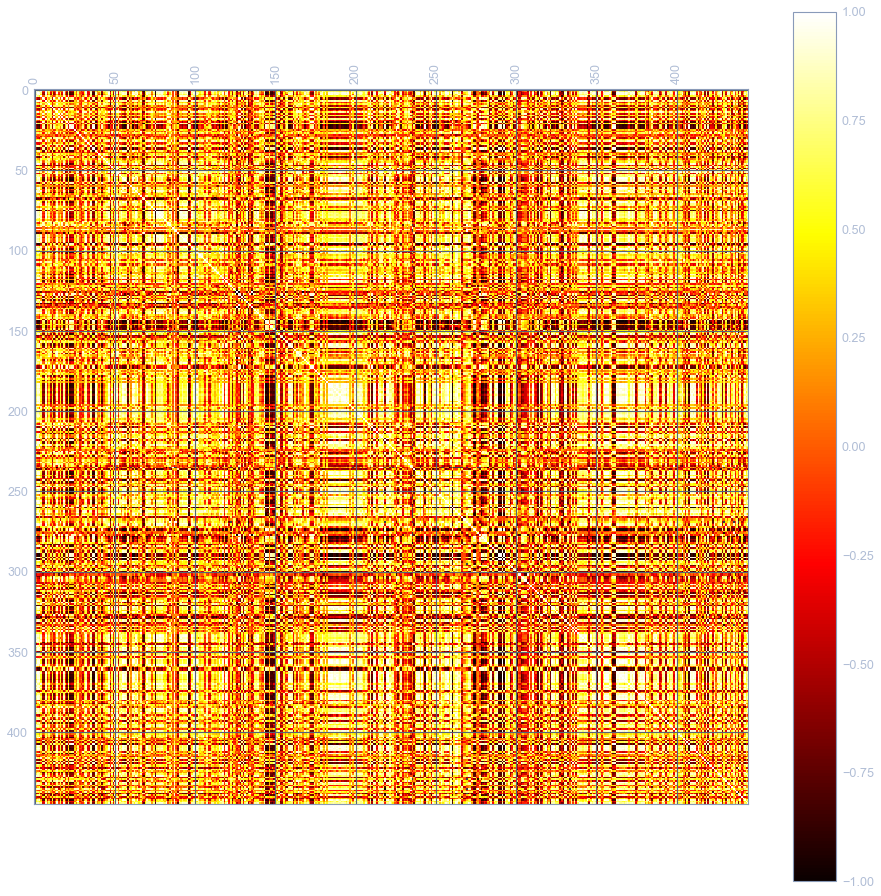

In [53]:
return_corr = historicals.reset_index().pivot('end','symbol')['total_returns'].corr()

alpha = list(historicals.reset_index('symbol'))

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
cax = ax.matshow(return_corr, interpolation='nearest', cmap='hot')
fig.colorbar(cax)
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
# ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# ax.set_xticklabels(['']+alpha)
# ax.set_yticklabels(['']+alpha)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

plt.show()

In [54]:
return_corr

symbol,AAAA.VN,AAXJ,ACWI,ACWV,AFK,AGG,AGQ,AOA,ASHX,AUSE,...,ZMT.TO,ZPL.TO,ZPR.TO,ZPS.L.TO,ZRE.TO,ZRR.TO,ZSL,ZSP.TO,ZWB.TO,ZXM.B.TO
symbol,,,,,,,,,,,,,,,,,,,,,
AAAA.VN,1.000000,0.424296,-0.032164,0.217975,0.494023,0.823494,0.741908,0.009801,0.648475,0.079239,...,0.608459,0.763654,-0.666721,0.919964,0.671513,0.000712,-0.796898,0.011879,-0.070637,-0.193919
AAXJ,0.424296,1.000000,0.888333,0.756366,0.919983,-0.133802,-0.218474,0.930805,0.388065,0.716240,...,0.866877,0.127514,0.674948,-0.533684,0.489272,-0.342271,-0.214561,0.509272,0.529174,0.890952
ACWI,-0.032164,0.888333,1.000000,0.935414,0.736569,-0.486614,-0.556798,0.955039,0.040401,0.543798,...,0.906561,-0.095437,0.651200,-0.414539,0.767773,-0.467505,0.158438,0.820185,0.657779,0.913884
ACWV,0.217975,0.756366,0.935414,1.000000,0.516886,-0.538663,-0.712734,0.850359,-0.195000,0.292321,...,0.859692,-0.089450,0.423307,0.350118,0.887958,-0.524925,0.346583,0.890995,0.484198,0.766694
AFK,0.494023,0.919983,0.736569,0.516886,1.000000,-0.020066,0.040944,0.797507,0.536453,0.804501,...,0.573770,0.119642,0.686513,-0.600298,0.255442,-0.199369,-0.433458,0.281150,0.521335,0.800513
AGG,0.823494,-0.133802,-0.486614,-0.538663,-0.020066,1.000000,0.774371,-0.252071,0.599479,0.250940,...,-0.075867,0.634510,-0.099870,0.021701,-0.660622,0.511062,-0.642149,-0.769231,-0.299095,-0.400066
AGQ,0.741908,-0.218474,-0.556798,-0.712734,0.040944,0.774371,1.000000,-0.382374,0.604194,0.271042,...,-0.237842,0.354332,-0.014083,-0.477795,-0.769398,0.513820,-0.864055,-0.816505,-0.190046,-0.352073
AOA,0.009801,0.930805,0.955039,0.850359,0.797507,-0.252071,-0.382374,1.000000,0.234868,0.703652,...,0.899183,0.027858,0.756135,-0.535532,0.625044,-0.414436,-0.012358,0.669176,0.687669,0.901199
ASHX,0.648475,0.388065,0.040401,-0.195000,0.536453,0.599479,0.604194,0.234868,1.000000,0.583651,...,0.701431,0.396781,0.271195,-0.434704,-0.456340,0.329311,-0.633696,-0.425381,0.192096,0.198979


In [58]:
s = return_corr.unstack()
so = s.sort_values(kind="quicksort")

In [62]:
so.describe()

count    197927.000000
mean          0.196240
std           0.532204
min          -1.000000
25%          -0.232190
50%           0.269219
75%           0.661010
max           1.000000
dtype: float64